In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob2 import glob  
import pandas_profiling
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

import xgboost as xgb

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [106]:
train_list = glob('./aT_data/data/train/*.csv')
train_list

['./aT_data/data/train/train_4.csv',
 './aT_data/data/train/train_15.csv',
 './aT_data/data/train/train_29.csv',
 './aT_data/data/train/train_28.csv',
 './aT_data/data/train/train_14.csv',
 './aT_data/data/train/train_5.csv',
 './aT_data/data/train/train_7.csv',
 './aT_data/data/train/train_16.csv',
 './aT_data/data/train/train_17.csv',
 './aT_data/data/train/train_6.csv',
 './aT_data/data/train/train_2.csv',
 './aT_data/data/train/train_13.csv',
 './aT_data/data/train/train_12.csv',
 './aT_data/data/train/train_3.csv',
 './aT_data/data/train/train_1.csv',
 './aT_data/data/train/train_10.csv',
 './aT_data/data/train/train_11.csv',
 './aT_data/data/train/train_0.csv',
 './aT_data/data/train/train_34.csv',
 './aT_data/data/train/train_20.csv',
 './aT_data/data/train/train_21.csv',
 './aT_data/data/train/train_35.csv',
 './aT_data/data/train/train_23.csv',
 './aT_data/data/train/train_36.csv',
 './aT_data/data/train/train_22.csv',
 './aT_data/data/train/train_26.csv',
 './aT_data/data/tra

In [103]:
df = pd.read_csv(train_list[0])
df

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,월구분_12월,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월
0,20130101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
1,20130102,1298.70,435.0,566065.50,3.0,350301.0,35030101.0,561.0,1587.314723,116539.0,...,0,1,0,0,0,0,0,0,0,0
2,20130103,929.07,1005.0,936562.50,5.0,350402.0,35040202.0,580.0,1731.765036,812663.0,...,0,1,0,0,0,0,0,0,0,0
3,20130104,960.96,360.0,346653.00,4.0,340101.0,34010102.0,330.0,1433.421743,282245.0,...,0,1,0,0,0,0,0,0,0,0
4,20130105,720.72,5400.0,3903900.00,1.0,311201.0,31120103.0,467.0,1549.518789,347766.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,20161227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1457,20161228,3663.66,1125.0,4121117.00,7.0,380201.0,38020102.0,680.0,3666.548045,237547.0,...,1,0,0,0,0,0,0,0,0,0
1458,20161229,2507.49,30.0,75315.24,1.0,311201.0,31120103.0,471.0,3652.588226,118475.0,...,1,0,0,0,0,0,0,0,0,0
1459,20161230,3793.79,1245.0,4713282.00,15.0,250001.0,25000102.0,314.0,3578.237741,83490.0,...,1,0,0,0,0,0,0,0,0,0


In [90]:
def feature_select(df):
       #시간 코사인 인코딩
       if df['datadate'].all() == 0:
         df['datadate'] = 20180520
       df['datetime'] = pd.to_datetime(df['datadate'], format="%Y%m%d")
       df['cos_time'] = np.cos(2*np.pi*df['datetime'].dt.dayofyear/365)

       # 결측치
       df = df.replace(' ', np.nan)

       # 주산지 초기온도, 최대온도, 최저온도, 평균온도, 강수량, 습도
       df['주산지_초기온도'] = (df['주산지_0_초기온도(℃)'] + df['주산지_1_초기온도(℃)'] + df['주산지_2_초기온도(℃)'])/3
       df['주산지_최대온도'] = (df['주산지_0_최대온도(℃)'] + df['주산지_1_최대온도(℃)'] + df['주산지_2_최대온도(℃)'])/3
       df['주산지_최저온도'] = (df['주산지_0_최저온도(℃)'] + df['주산지_1_최저온도(℃)'] + df['주산지_2_최저온도(℃)'])/3
       df['주산지_평균온도'] = (df['주산지_0_평균온도(℃)'] + df['주산지_1_평균온도(℃)'] + df['주산지_2_평균온도(℃)'])/3
       df['주산지_강수량'] = (df['주산지_0_강수량(ml)'] + df['주산지_1_강수량(ml)'] + df['주산지_2_강수량(ml)'])/3

       # 필요한 컬럼 선택
       
       market_cols = ['단가(원)', '거래량'] # '경매건수',, '거래대금(원)'

       market_code_cols = [] # '도매시장코드', '도매법인코드', '산지코드 '

       market_statistics_cols = [ '일자별_도매가격_평균(원)', '해당일자_전체거래물량(kg)'
                                 ] 
       # '상위가격 평균가(원)',  '하위가격 평균가(원)',
       # '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)', '일자별_소매가격_최소( 원)',
       #  '하위가격 거래물량(kg)', '상위가격 거래물량(kg)',
       #  '일자별_도매가격_최대(원)','일자별_도매가격_최소(원)', , 
       
       export_cols = [] # '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)', '무역수지(달러)'
       
       date_cols = ['cos_time'] 
       # '일자구분_중순', '일자구분_초순', '일자구분_하순', '월구분_10월', '월구분_11월', '월구분_12월', '월구분_1월', '월구분_2월','월구분_3월', '월구분_4월', '월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월', 'datetime'

       weather_cols = ['주산지_평균온도', '주산지_강수량'] 
       # '주산지_초기온도', '주산지_최대온도', '주산지_최저온도', 
      #  '주산지_0_초기온도(℃)', '주산지_1_초기온도(℃)', '주산지_2_초기온도(℃)',
      #  '주산지_0_최대온도(℃)', '주산지_1_최대온도(℃)', '주산지_2_최대온도(℃)',
      #  '주산지_0_최저온도(℃)', '주산지_1_최저온도(℃)', '주산지_2_최저온도(℃)',
      #  '주산지_0_평균온도(℃)', '주산지_1_평균온도(℃)', '주산지_2_평균온도(℃)',
      #  '주산지_0_강수량(ml)', '주산지_1_강수량(ml)', '주산지_2_강수량(ml)',
      #  '주산지_0_습도(%)', '주산지_1_습도(%)', '주산지_2_습도(%)'

       selected_columns = ['datadate', '해당일자_전체평균가격(원)']  + market_cols + market_code_cols + market_statistics_cols + export_cols +  date_cols + weather_cols # train 에서 사용하지 않는 열
       df = df[[c for c in df.columns if c in selected_columns]]

       return df

In [91]:
def feature_scale(df):
    scaler = RobustScaler()
    scale_columns = [c for c in df.columns if c not in ['datadate', 'cos_time']]
    
    df[scale_columns] = scaler.fit_transform(df[scale_columns])

    return df

In [92]:
def feature_na(df):
    df = df.interpolate()
    df = df.fillna(method = 'bfill')

    return df

In [93]:
df = feature_select(df)
df = feature_scale(df)
df = feature_na(df)
df

,datadate,단가(원),거래량,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),일자별_도매가격_평균(원),cos_time,주산지_평균온도,주산지_강수량
0,20130101,-0.441031,-0.424621,-0.343993,-0.357797,-0.410256,0.999852,-0.537634,-0.200000
1,20130102,-0.441031,-0.424621,-0.343993,-0.357797,-0.410256,0.999407,-0.344086,-0.200000
2,20130103,-0.752658,-0.049375,-0.194723,3.059190,-0.410256,0.998667,-0.526882,-0.200000
3,20130104,-0.725772,-0.473996,-0.503021,0.455586,-0.410256,0.997630,-0.503226,-0.200000
4,20130105,-0.928313,2.843976,-0.383050,0.777202,-0.346154,0.996298,-0.556989,0.351724
...,...,...,...,...,...,...,...,...,...
1456,20161227,1.465505,-0.197498,1.736683,-0.187111,1.687500,0.998667,-0.513978,0.724138
1457,20161228,1.552815,0.029625,1.804613,0.236182,1.683333,0.999407,-0.440860,1.110345
1458,20161229,0.578073,-0.691244,1.790187,-0.348294,1.683333,0.999852,-0.638710,0.000000
1459,20161230,1.662524,0.108624,1.713356,-0.520021,1.683333,1.000000,-1.247312,-0.089655


In [94]:
df['datetime'] = pd.to_datetime(df['datadate'], format="%Y%m%d")
df = df.set_index('datetime')

df

,datadate,단가(원),거래량,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),일자별_도매가격_평균(원),cos_time,주산지_평균온도,주산지_강수량
datetime,,,,,,,,,
2013-01-01,20130101,-0.441031,-0.424621,-0.343993,-0.357797,-0.410256,0.999852,-0.537634,-0.200000
2013-01-02,20130102,-0.441031,-0.424621,-0.343993,-0.357797,-0.410256,0.999407,-0.344086,-0.200000
2013-01-03,20130103,-0.752658,-0.049375,-0.194723,3.059190,-0.410256,0.998667,-0.526882,-0.200000
2013-01-04,20130104,-0.725772,-0.473996,-0.503021,0.455586,-0.410256,0.997630,-0.503226,-0.200000
2013-01-05,20130105,-0.928313,2.843976,-0.383050,0.777202,-0.346154,0.996298,-0.556989,0.351724
...,...,...,...,...,...,...,...,...,...
2016-12-27,20161227,1.465505,-0.197498,1.736683,-0.187111,1.687500,0.998667,-0.513978,0.724138
2016-12-28,20161228,1.552815,0.029625,1.804613,0.236182,1.683333,0.999407,-0.440860,1.110345
2016-12-29,20161229,0.578073,-0.691244,1.790187,-0.348294,1.683333,0.999852,-0.638710,0.000000


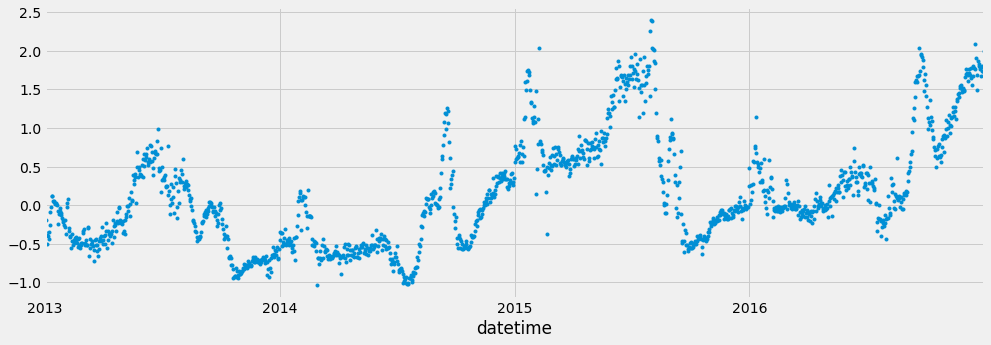

In [95]:
df['해당일자_전체평균가격(원)'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='')
plt.show()

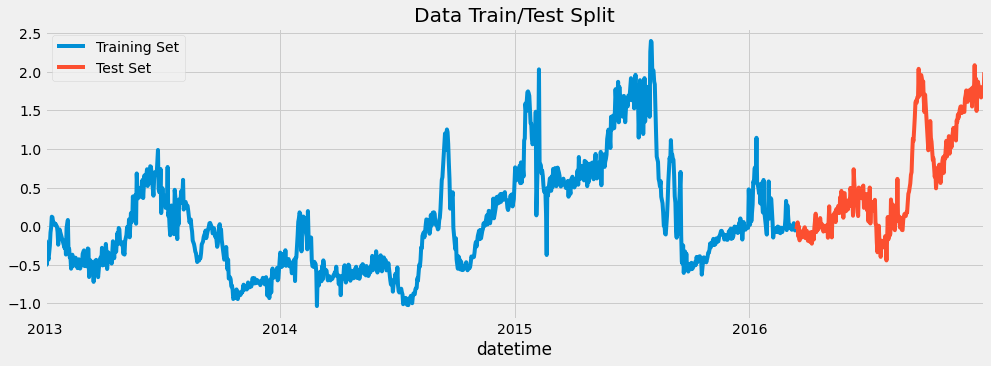

In [96]:
cut = int(len(df4)*0.8)

train = df.iloc[:cut]
test = df.iloc[cut:]

fig, ax = plt.subplots(figsize=(15, 5))
train['해당일자_전체평균가격(원)'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['해당일자_전체평균가격(원)'].plot(ax=ax, label='Test Set')
# ax.axvline(, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

IndexError: index 5 is out of bounds for axis 0 with size 5

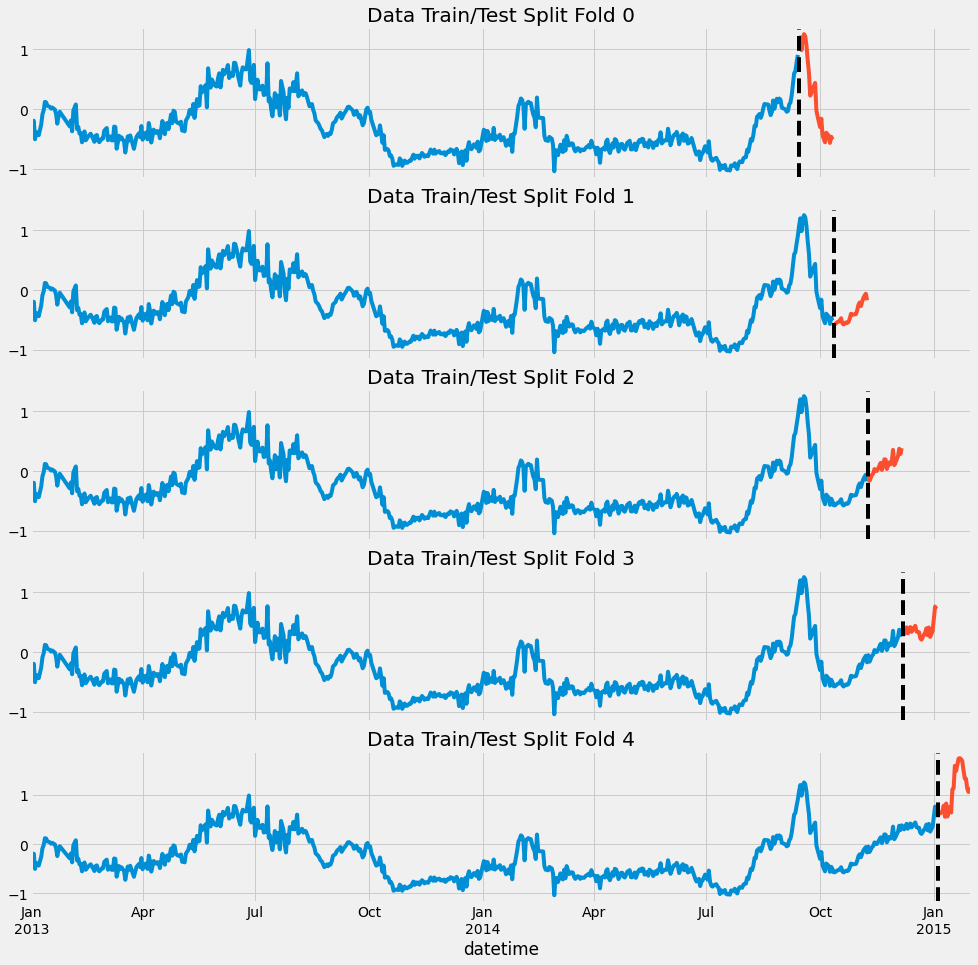

In [98]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=30, test_size=28, gap=0)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['해당일자_전체평균가격(원)'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['해당일자_전체평균가격(원)'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [101]:
tss = TimeSeriesSplit(n_splits=30, test_size=28, gap=0)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = ['단가(원)', '거래량', '해당일자_전체거래물량(kg)',
       '일자별_도매가격_평균(원)', 'cos_time', '주산지_평균온도', '주산지_강수량']

    TARGET = '해당일자_전체평균가격(원)'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


[20:50:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1662013895516/work/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.91328	validation_1-rmse:0.70208
[100]	validation_0-rmse:0.38242	validation_1-rmse:0.47996
[164]	validation_0-rmse:0.24918	validation_1-rmse:0.48932
[20:50:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1662013895516/work/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.90524	validation_1-rmse:0.90515
[100]	validation_0-rmse:0.38535	validation_1-rmse:0.27436
[200]	validation_0-rmse:0.21702	validation_1-rmse:0.13711
[244]	validation_0-rmse:0.18553	validation_1-rmse:0.15743
[20:50:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1662013895516/work/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.90532	validation_1-rms

In [100]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.3223
Fold scores:[0.4762861302057723, 0.13687380344215389, 0.09813968194496661, 0.11252813541373251, 0.7183556329570965, 0.4707884477362783, 0.12302529623581025, 0.19692089962093762, 0.2867960600209326, 0.7960790459965753, 0.5282761461860095, 0.6469937405800822, 0.35172097072850483, 0.2839713824594657, 0.10377874086869364, 0.14445488152728825, 0.16956817504921248, 0.22739705250728537, 0.25754274673284144, 0.16628410078000563, 0.2182468421628779, 0.43309289811152635, 0.20119474943906615, 0.22962794339303416, 0.6368687200711028, 0.28026671109851536, 0.7105978248185226, 0.15457889461399363, 0.2858652782901106, 0.22330791160647057]


In [108]:
test_list = glob('./aT_data/data/test/set_0/*.csv')
test_list[21]

'./aT_data/data/test/set_0/test_4.csv'

In [110]:
df_test = pd.read_csv(test_list[21])
df_test

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,주산지_1_습도(%),주산지_2_초기온도(℃),주산지_2_최대온도(℃),주산지_2_최저온도(℃),주산지_2_평균온도(℃),주산지_2_강수량(ml),주산지_2_습도(%),일자구분_중순,일자구분_초순,월구분_1월
0,20170101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,-6.3,-1.0,-7.1,-4.1,0.0,29.0,0,1,1
1,20170102,3216.78,720.0,2322420.10,9.0,380401.0,38040102.0,660.0,3436.169453,5850.0,...,,-2.9,-1.0,-6.8,-3.8,0.0,19.2,0,1,1
2,20170103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,-3.6,-1.0,-5.9,-3.5,0.0,16.2,0,1,1
3,20170104,4044.04,5010.0,20226453.30,31.0,210009.0,21000903.0,330.0,3958.419274,489487.0,...,,-2.4,3.0,-7.9,-2.4,0.0,26.9,0,1,1
4,20170105,3676.32,1680.0,6175118.70,13.0,250001.0,25000102.0,314.0,3656.660137,85691.0,...,,-3.0,-1.0,-7.2,-4.1,0.0,34.9,0,1,1
5,20170106,9099.09,20.0,182011.83,2.0,320101.0,32010101.0,680.0,3716.841372,101375.0,...,,-6.9,-2.6,-10.6,-6.6,0.0,24.1,0,1,1
6,20170107,3796.20,465.0,1768166.40,6.0,320201.0,32020101.0,220.0,4065.667294,75045.0,...,,-6.3,-6.3,-15.1,-11.7,0.0,26.8,0,1,1
7,20170108,3106.89,630.0,1958139.90,8.0,370101.0,37010101.0,770.0,3786.003069,35115.0,...,,-14.0,-9.5,-15.9,-12.6,0.0,20.4,0,1,1
8,20170109,3306.69,330.0,1089909.00,7.0,360301.0,36030102.0,542.0,3837.993324,10455.0,...,,-13.1,-5.7,-15.4,-10.4,0.0,28.0,0,1,1
9,20170110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,-11.8,-1.0,-13.9,-7.6,0.0,38.2,0,1,1


In [112]:
df_test = feature_select(df_test)
df_test = feature_scale(df_test)
df_test = feature_na(df_test)
df_test

,datadate,단가(원),거래량,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),일자별_도매가격_평균(원),cos_time,주산지_평균온도,주산지_강수량
0,20170101,-0.397413,0.000000,-1.953217,-0.610954,-0.142857,0.999852,0.070081,0.033333
1,20170102,-0.397413,0.000000,-1.953217,-0.610954,-0.142857,0.999407,0.253369,-0.966667
2,20170103,-0.113712,1.153226,-0.795965,1.239474,-0.142857,0.998667,-0.070081,-0.966667
3,20170104,0.169989,2.306452,0.361288,3.089901,-0.142857,0.997630,0.501348,-0.966667
4,20170105,-0.082223,0.516129,-0.976047,0.000000,0.000000,0.996298,0.264151,-0.966667
5,20170106,3.637149,-0.376344,-0.709336,0.120016,0.000000,0.994671,-0.576819,-0.966667
6,20170107,0.000000,-0.137097,0.836589,-0.081465,0.000000,0.992749,-2.204852,1.033333
7,20170108,-0.472784,-0.048387,-0.402826,-0.387014,0.000000,0.990532,-2.442049,1.433333
8,20170109,-0.335745,-0.209677,-0.172416,-0.575716,0.095238,0.988023,-1.902965,-0.033333
9,20170110,-0.539445,0.040323,0.183174,0.194739,0.190476,0.985220,-0.792453,0.033333


In [114]:
FEATURES = ['단가(원)', '거래량', '해당일자_전체거래물량(kg)',
       '일자별_도매가격_평균(원)', 'cos_time', '주산지_평균온도', '주산지_강수량']
       
df_test['prediction'] = reg.predict(df_test[FEATURES])

df_test

,datadate,단가(원),거래량,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),일자별_도매가격_평균(원),cos_time,주산지_평균온도,주산지_강수량,prediction
0,20170101,-0.397413,0.000000,-1.953217,-0.610954,-0.142857,0.999852,0.070081,0.033333,-0.015185
1,20170102,-0.397413,0.000000,-1.953217,-0.610954,-0.142857,0.999407,0.253369,-0.966667,0.002446
2,20170103,-0.113712,1.153226,-0.795965,1.239474,-0.142857,0.998667,-0.070081,-0.966667,-0.009219
3,20170104,0.169989,2.306452,0.361288,3.089901,-0.142857,0.997630,0.501348,-0.966667,0.186252
4,20170105,-0.082223,0.516129,-0.976047,0.000000,0.000000,0.996298,0.264151,-0.966667,0.066700
5,20170106,3.637149,-0.376344,-0.709336,0.120016,0.000000,0.994671,-0.576819,-0.966667,0.157737
6,20170107,0.000000,-0.137097,0.836589,-0.081465,0.000000,0.992749,-2.204852,1.033333,0.068659
7,20170108,-0.472784,-0.048387,-0.402826,-0.387014,0.000000,0.990532,-2.442049,1.433333,0.033225
8,20170109,-0.335745,-0.209677,-0.172416,-0.575716,0.095238,0.988023,-1.902965,-0.033333,0.209876
9,20170110,-0.539445,0.040323,0.183174,0.194739,0.190476,0.985220,-0.792453,0.033333,0.278423


In [116]:
score = np.sqrt(mean_squared_error(df_test['해당일자_전체평균가격(원)'], df_test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1.01
